<a href="https://colab.research.google.com/github/CalculatedContent/WeightWatcher-Examples/blob/main/MLP3_CIFAR10ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP3 on CIFAR 10:  Extreme Overfitting in the First Layer

3-Layer MLP trained on CIIt is well-known empirically that early layers often become too specialized to the training data, especially on vision datasets without convolution (like your MLP on CIFAR).

This shows up as:

● Early-layer weight norms grow

● Spectral norms grow

● Rank increases → memorizing fine-grained pixel patterns

● Filters become overly specific to training samples

This phenomenon is referred to in the literature as:
	•	Over-specialization of early layers
	•	Shattering / exploding gradients in early layers
	•	Memorization layers
	•	Feature drift
	•	Input-layer sensitivity to data augmentation

So even without HTSR theory, practitioners have observed and documented:

Early layers tend to overfit more than deeper layers when the model architecture has no spatial or structural biases (e.g., MLP on images).

This is why:
	•	CNNs enforce locality & weight sharing → prevents this problem
	•	ViTs use patch embeddings & positional encodings → prevents this
	•	MLPs on raw pixels do neither → first layer absorbs ALL variation

⸻


In [ ]:
# ============================================================
# CIFAR-10 3-layer MLP + WeightWatcher every N epochs
# ============================================================
import os, math, time, random
from dataclasses import dataclass

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


!pip install weightwatcher
from weightwatcher import WeightWatcher

# -------------------------
# Hyperparameters
# -------------------------
@dataclass
class HParams:
    # Model
    hidden1: int = 2048
    hidden2: int = 1024
    dropout: float = 0.20

    # Training
    epochs: int = 120
    batch_size: int = 256
    base_lr: float = 0.05            # for SGD+Nesterov
    weight_decay: float = 5e-4
    warmup_epochs: int = 5
    min_lr_ratio: float = 0.01
    label_smoothing: float = 0.05
    clip_grad_norm: float = 0.0

    # Misc
    num_workers: int = 4
    data_dir: str = "./data"
    seed: int = 123

hp = HParams()
ww_every = 5   # <-- run WeightWatcher every N epochs

# -------------------------
# Reproducibility
# -------------------------
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(hp.seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------------
# Dataloaders
#   - train_aug: used for optimization (random crop + flip)
#   - train_clean: same data, no augmentation (for "real" train acc)
#   - test: standard CIFAR-10 test
# -------------------------
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2470, 0.2435, 0.2616)

transform_train_aug = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_clean = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_test = transform_clean

train_aug_dataset = datasets.CIFAR10(
    root=hp.data_dir, train=True, download=True, transform=transform_train_aug
)
train_clean_dataset = datasets.CIFAR10(
    root=hp.data_dir, train=True, download=False, transform=transform_clean
)
test_dataset = datasets.CIFAR10(
    root=hp.data_dir, train=False, download=False, transform=transform_test
)

train_loader = DataLoader(
    train_aug_dataset,
    batch_size=hp.batch_size,
    shuffle=True,
    num_workers=hp.num_workers,
    pin_memory=True,
)

train_clean_loader = DataLoader(
    train_clean_dataset,
    batch_size=hp.batch_size,
    shuffle=False,
    num_workers=hp.num_workers,
    pin_memory=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=hp.batch_size,
    shuffle=False,
    num_workers=hp.num_workers,
    pin_memory=True,
)

steps_per_epoch = len(train_loader)
print("Steps per epoch:", steps_per_epoch)

# -------------------------
# Model: 3-layer MLP
#   Input: 3*32*32 = 3072
# -------------------------
class MLP3CIFAR(nn.Module):
    def __init__(self, hp: HParams):
        super().__init__()
        in_dim = 3 * 32 * 32
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_dim, hp.hidden1),   # fc1
            nn.GELU(),
            nn.Dropout(hp.dropout),
            nn.Linear(hp.hidden1, hp.hidden2),  # fc2
            nn.GELU(),
            nn.Dropout(hp.dropout),
            nn.Linear(hp.hidden2, 10),       # fc3
        )

    def forward(self, x):
        return self.net(x)

model = MLP3CIFAR(hp).to(device)
print(model)

# -------------------------
# Optimizer + LR schedule
# -------------------------
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=hp.base_lr,
    momentum=0.9,
    nesterov=True,
    weight_decay=hp.weight_decay,
)

criterion = nn.CrossEntropyLoss(label_smoothing=hp.label_smoothing)

total_steps = hp.epochs * steps_per_epoch
warmup_steps = hp.warmup_epochs * steps_per_epoch
min_lr = hp.base_lr * hp.min_lr_ratio

def set_lr(step: int):
    """Cosine schedule with linear warmup."""
    if warmup_steps > 0 and step < warmup_steps:
        lr = hp.base_lr * float(step + 1) / float(warmup_steps)
    else:
        if total_steps <= warmup_steps:
            t = 1.0
        else:
            t = float(step - warmup_steps) / float(total_steps - warmup_steps)
        cosine = 0.5 * (1.0 + math.cos(math.pi * t))
        lr = min_lr + (hp.base_lr - min_lr) * cosine
    for pg in optimizer.param_groups:
        pg["lr"] = lr
    return lr

# -------------------------
# Evaluation helper
# -------------------------
@torch.no_grad()
def evaluate(model, loader, criterion, desc="eval"):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)
        _, pred = logits.max(1)
        correct += pred.eq(y).sum().item()
        total += y.size(0)
    avg_loss = total_loss / total
    acc = correct / total
    return avg_loss, acc

# -------------------------
# WeightWatcher helper
#   - Run full WW analyze()
#   - Extract α for the 3 Linear layers (fc1, fc2, fc3) by order
# -------------------------
def run_weightwatcher_on_mlp(model: nn.Module):
    ww = WeightWatcher(model=model)
    details = ww.analyze(plot=False, savefig=False)

    # details may be a DataFrame or a list of dicts
    if isinstance(details, pd.DataFrame):
        rows = details.to_dict(orient="records")
    else:
        rows = list(details)

    # try to pick out Linear layers
    linear_rows = []
    for r in rows:
        lt = str(r.get("layer_type", "")).lower()
        if "linear" in lt or "fc" in lt or "dense" in lt:
            linear_rows.append(r)

    # Fallback: if we didn't detect by layer_type, just use rows with 'alpha'
    if len(linear_rows) == 0:
        linear_rows = [r for r in rows if "alpha" in r]

    # Sort by layer_id if present
    if all("layer_id" in r for r in linear_rows):
        linear_rows = sorted(linear_rows, key=lambda r: r["layer_id"])

    alphas = [float(r.get("alpha", np.nan)) for r in linear_rows]
    # Pad / truncate to 3 to match fc1, fc2, fc3
    while len(alphas) < 3:
        alphas.append(np.nan)
    if len(alphas) > 3:
        alphas = alphas[:3]

    alpha_fc1, alpha_fc2, alpha_fc3 = alphas
    return alpha_fc1, alpha_fc2, alpha_fc3

# -------------------------
# Training loop
# -------------------------
history = {
    "epoch": [],
    "lr": [],
    "train_loss": [],
    "train_acc": [],
    "train_clean_loss": [],
    "train_clean_acc": [],
    "test_loss": [],
    "test_acc": [],
    # WeightWatcher every ww_every epochs
    "ww_epoch": [],
    "ww_alpha_fc1": [],
    "ww_alpha_fc2": [],
    "ww_alpha_fc3": [],
}

global_step = 0
best_test_acc = 0.0
best_state_dict = None

for epoch in range(1, hp.epochs + 1):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    t0 = time.time()
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        # LR schedule
        lr = set_lr(global_step)
        global_step += 1

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        if hp.clip_grad_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), hp.clip_grad_norm)
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        _, pred = logits.max(1)
        running_correct += pred.eq(y).sum().item()
        running_total += y.size(0)

    train_loss = running_loss / running_total
    train_acc = running_correct / running_total

    # Clean train + test evaluation
    train_clean_loss, train_clean_acc = evaluate(model, train_clean_loader, criterion, desc="train_clean")
    test_loss, test_acc = evaluate(model, test_loader, criterion, desc="test")

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_state_dict = {k: v.cpu() for k, v in model.state_dict().items()}

    history["epoch"].append(epoch)
    history["lr"].append(lr)
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["train_clean_loss"].append(train_clean_loss)
    history["train_clean_acc"].append(train_clean_acc)
    history["test_loss"].append(test_loss)
    history["test_acc"].append(test_acc)

    # ---- WeightWatcher every ww_every epochs ----
    if epoch % ww_every == 0:
        alpha_fc1, alpha_fc2, alpha_fc3 = run_weightwatcher_on_mlp(model)
        history["ww_epoch"].append(epoch)
        history["ww_alpha_fc1"].append(alpha_fc1)
        history["ww_alpha_fc2"].append(alpha_fc2)
        history["ww_alpha_fc3"].append(alpha_fc3)
        print(f"[WW] epoch={epoch}  α(fc1)={alpha_fc1:.3f}  α(fc2)={alpha_fc2:.3f}  α(fc3)={alpha_fc3:.3f}")

    dt = time.time() - t0
    print(
        f"[Epoch {epoch:03d}/{hp.epochs}] "
        f"lr={lr:.4e} "
        f"train_loss={train_loss:.4f} acc={train_acc:.4f} | "
        f"train_clean_acc={train_clean_acc:.4f} | "
        f"test_acc={test_acc:.4f} | "
        f"time={dt:.1f}s"
    )

print(f"\nBest test accuracy: {best_test_acc:.4f}")

# Optionally reload best model state
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    print("Loaded best model state (by test_acc).")



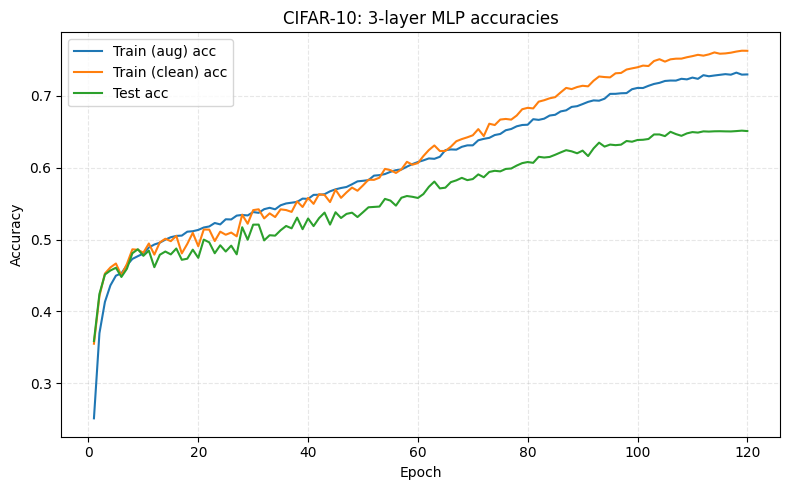

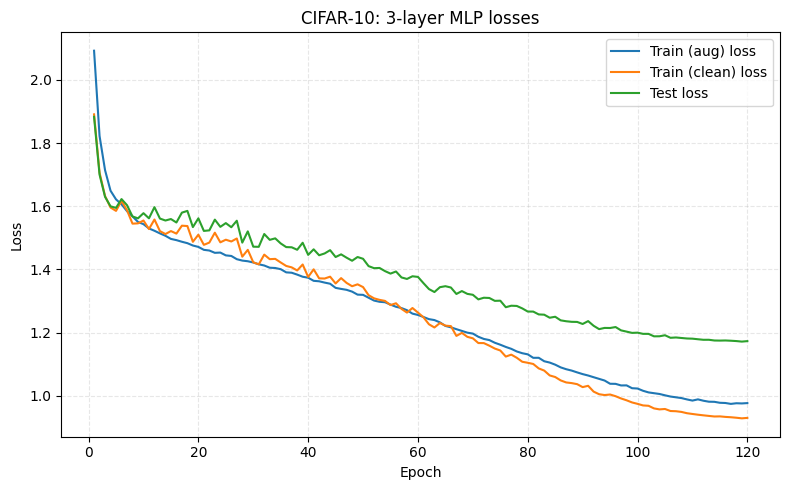

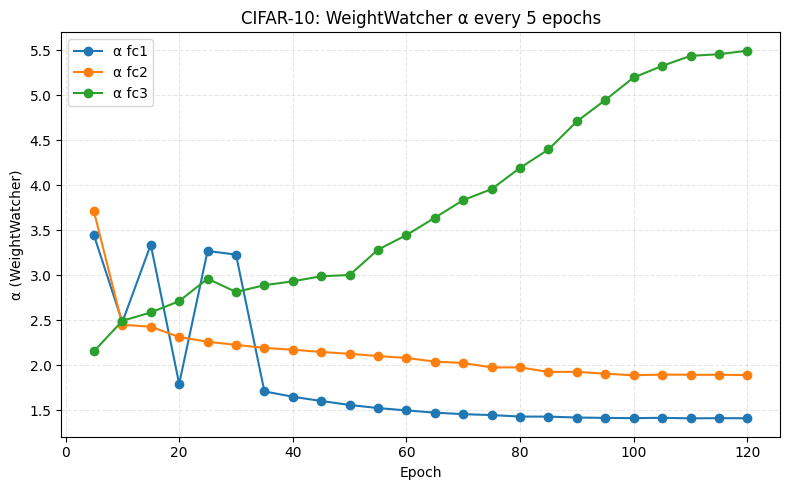

In [19]:
# -------------------------
# Plots: accuracies + losses
# -------------------------


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

epochs = history["epoch"]

plt.figure(figsize=(8, 5))
plt.plot(epochs, history["train_acc"], label="Train (aug) acc")
plt.plot(epochs, history["train_clean_acc"], label="Train (clean) acc")
plt.plot(epochs, history["test_acc"], label="Test acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CIFAR-10: 3-layer MLP accuracies")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs, history["train_loss"], label="Train (aug) loss")
plt.plot(epochs, history["train_clean_loss"], label="Train (clean) loss")
plt.plot(epochs, history["test_loss"], label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CIFAR-10: 3-layer MLP losses")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------
# Plot α for fc1/fc2/fc3 vs epoch (only WW epochs)
# -------------------------
if len(history["ww_epoch"]) > 0:
    ww_epochs = history["ww_epoch"]
    plt.figure(figsize=(8, 5))
    plt.plot(ww_epochs, history["ww_alpha_fc1"], marker="o", label="α fc1")
    plt.plot(ww_epochs, history["ww_alpha_fc2"], marker="o", label="α fc2")
    plt.plot(ww_epochs, history["ww_alpha_fc3"], marker="o", label="α fc3")
    plt.xlabel("Epoch")
    plt.ylabel("α (WeightWatcher)")
    plt.title(f"CIFAR-10: WeightWatcher α every {ww_every} epochs")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

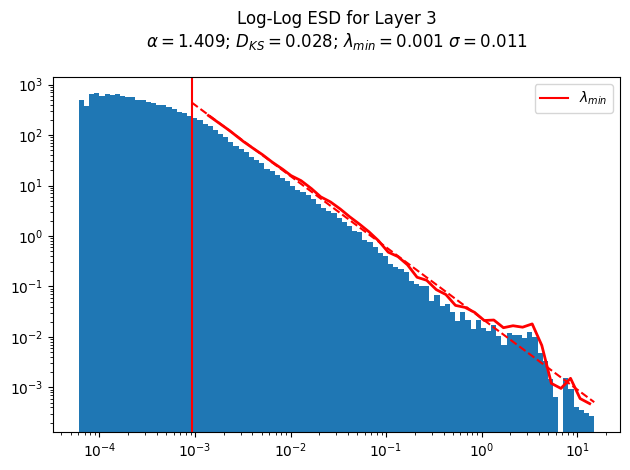

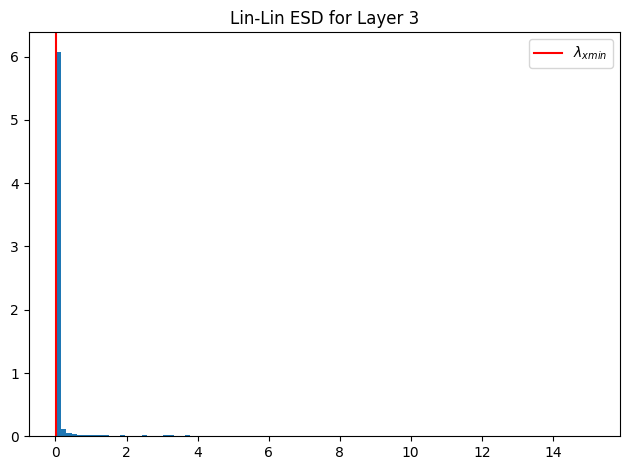

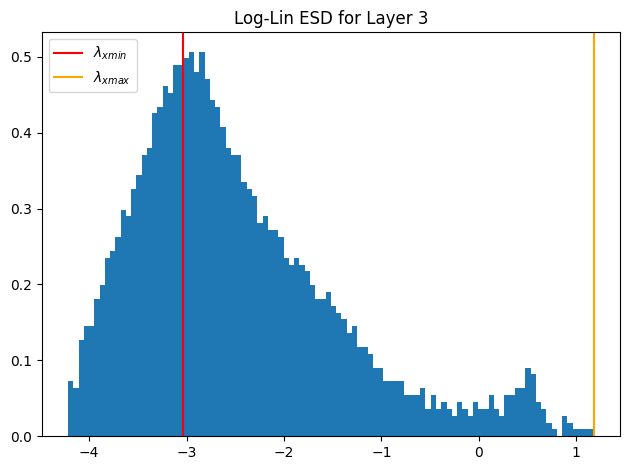

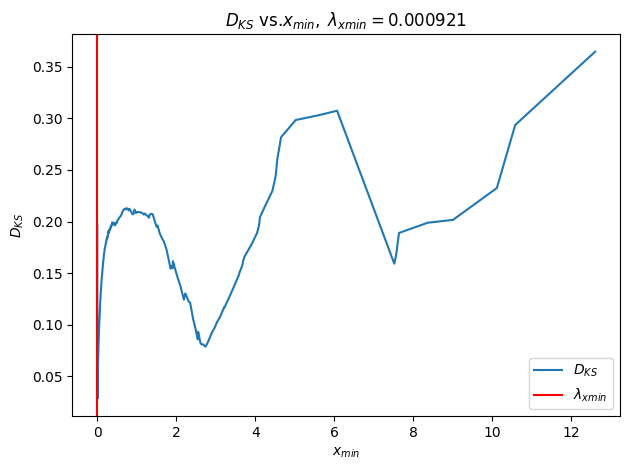

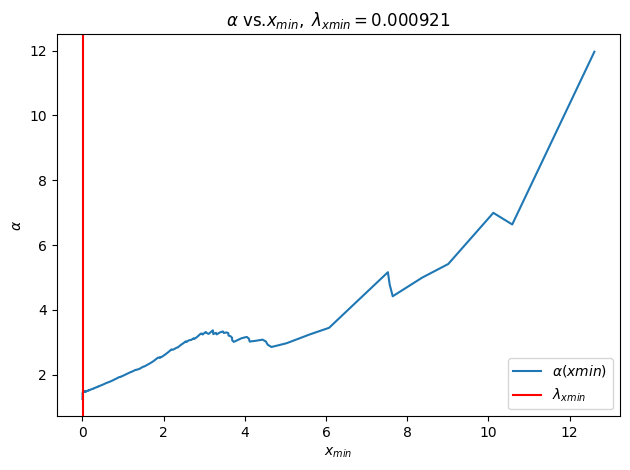

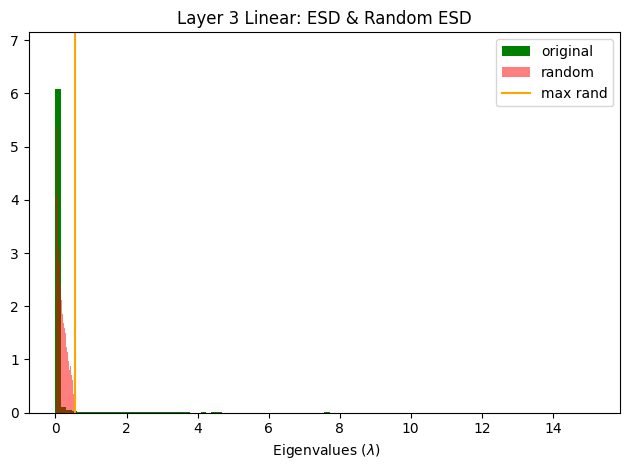

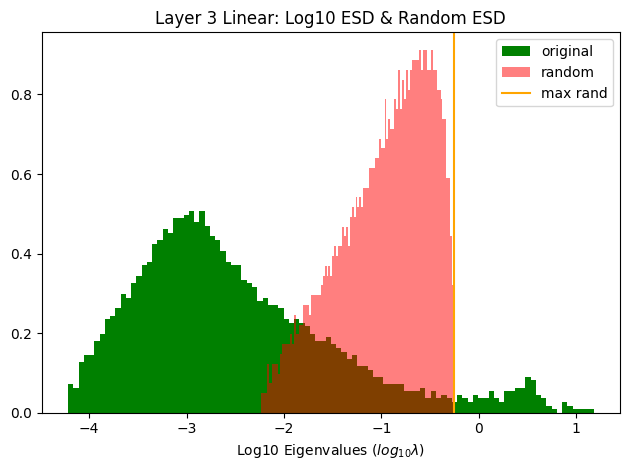

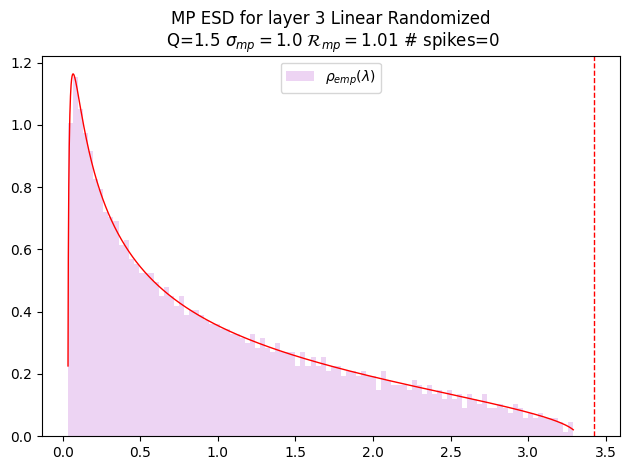

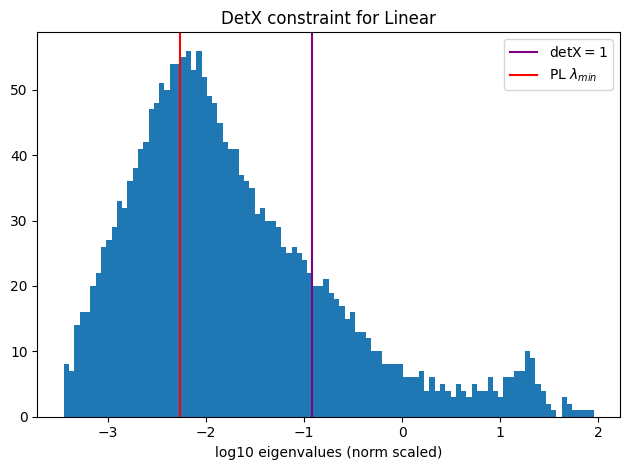

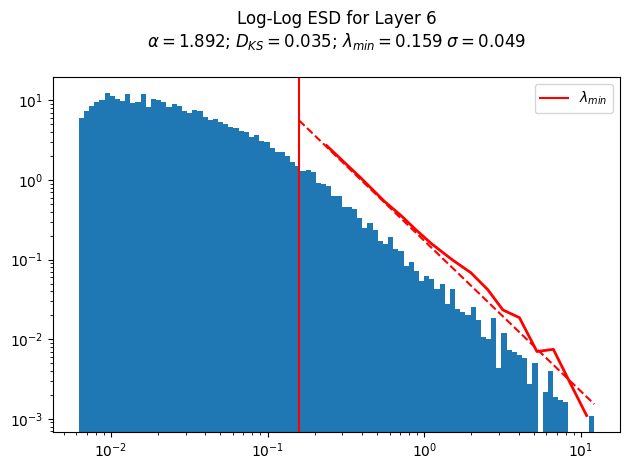

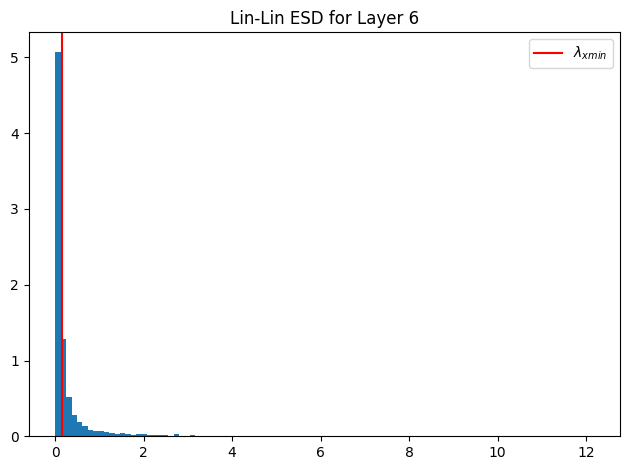

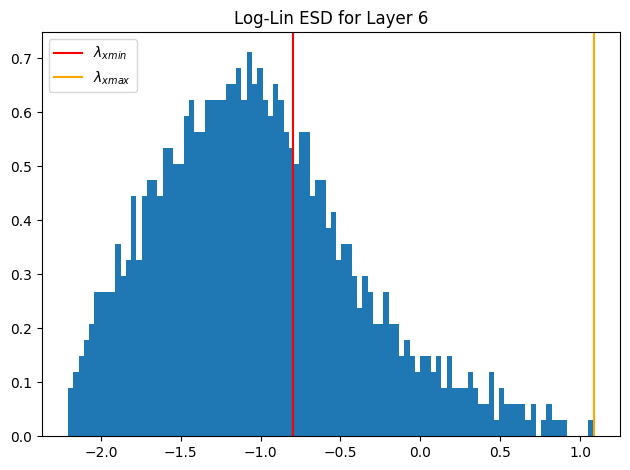

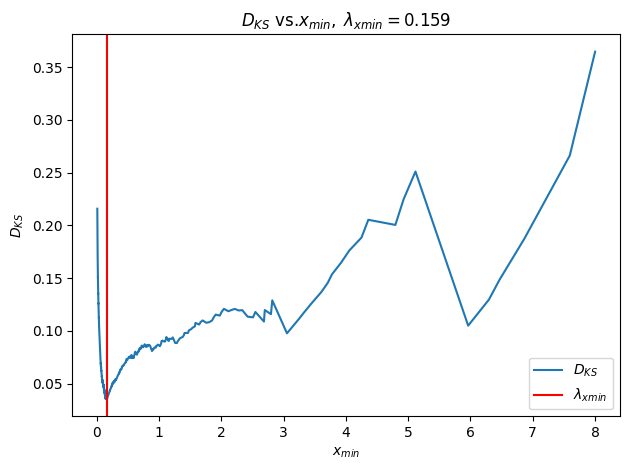

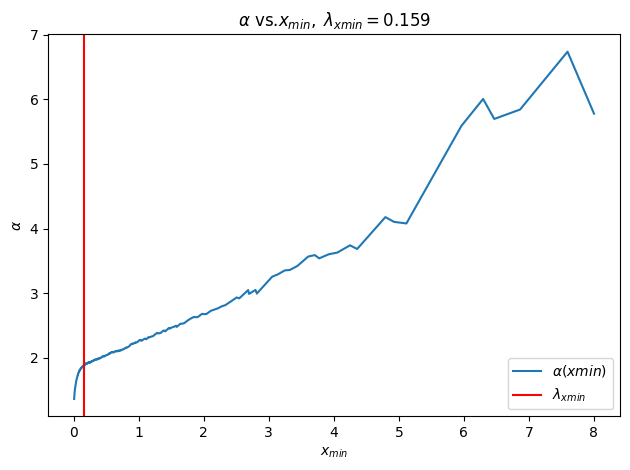

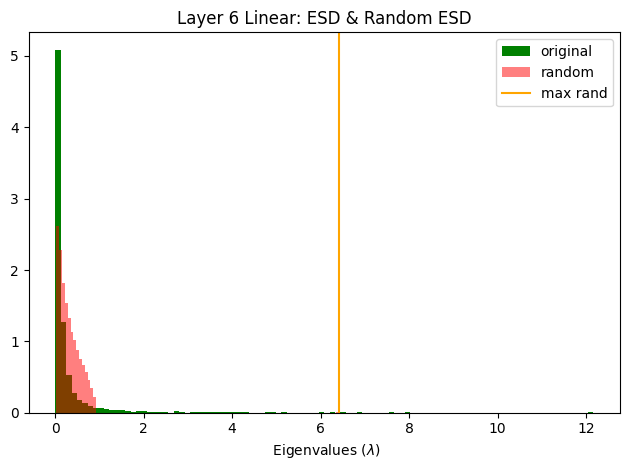

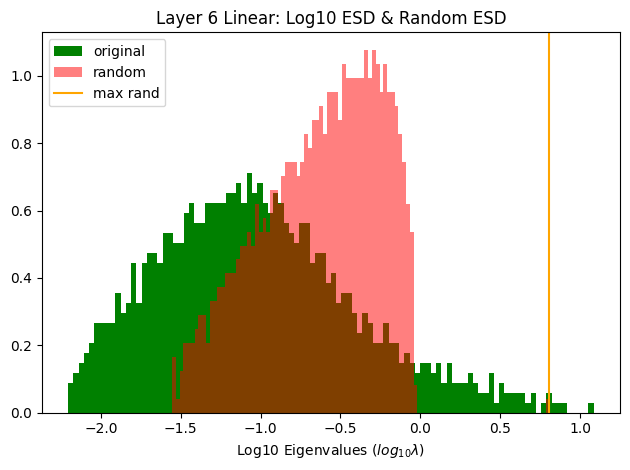

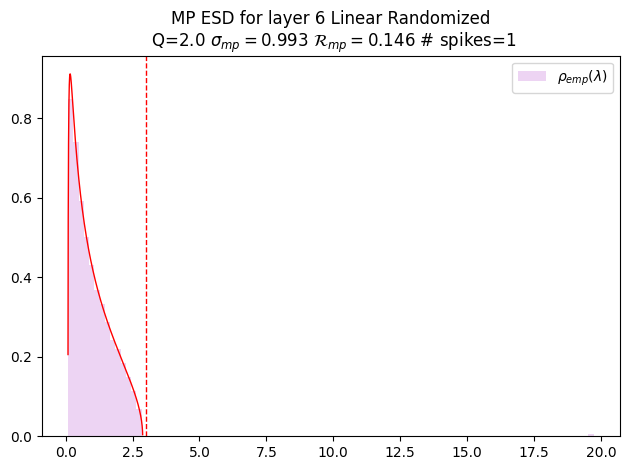

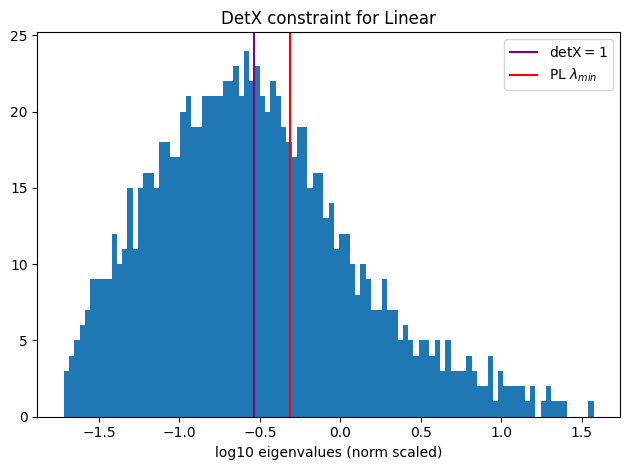

SMALL N PL FIT


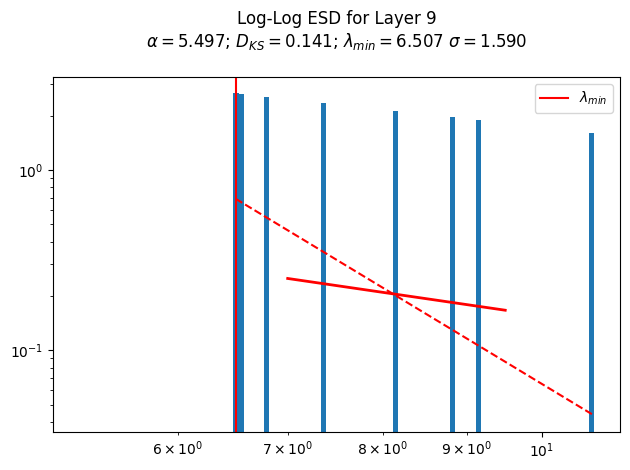

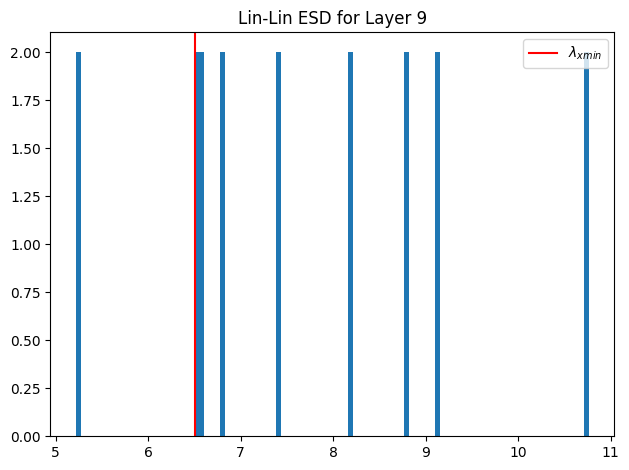

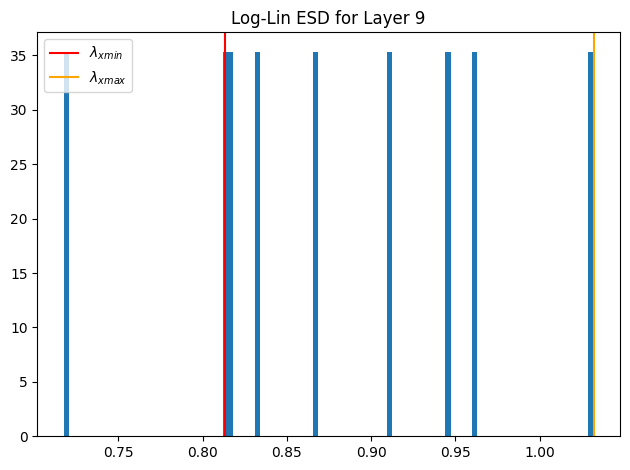

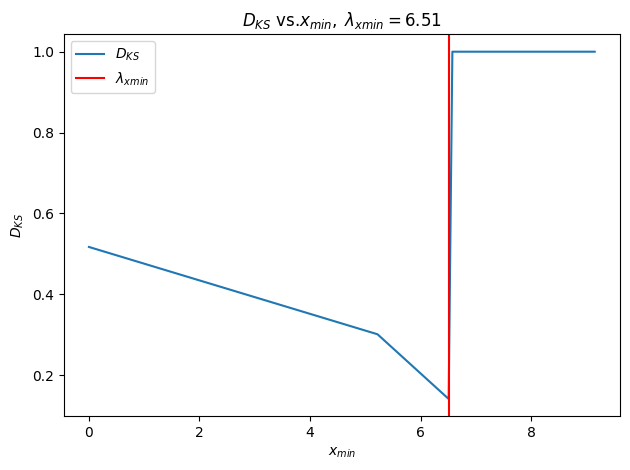

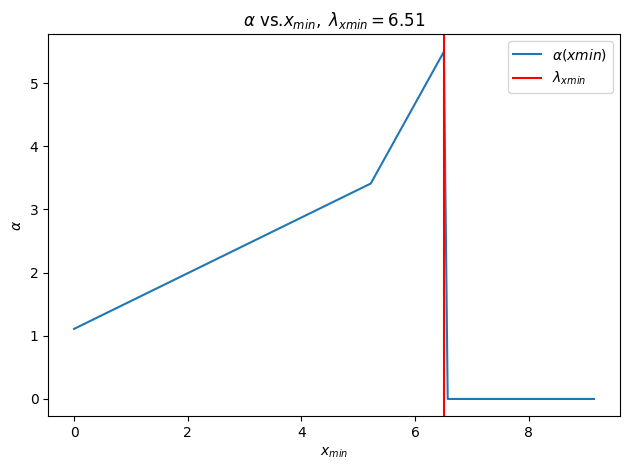

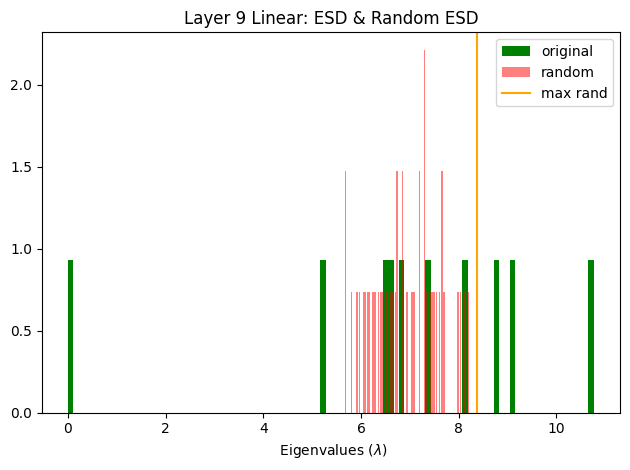

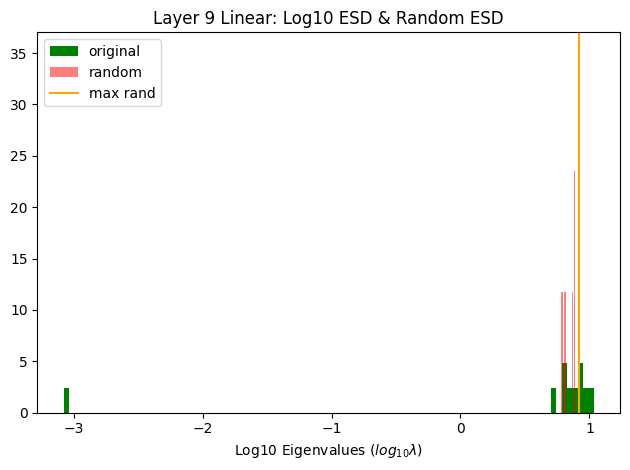

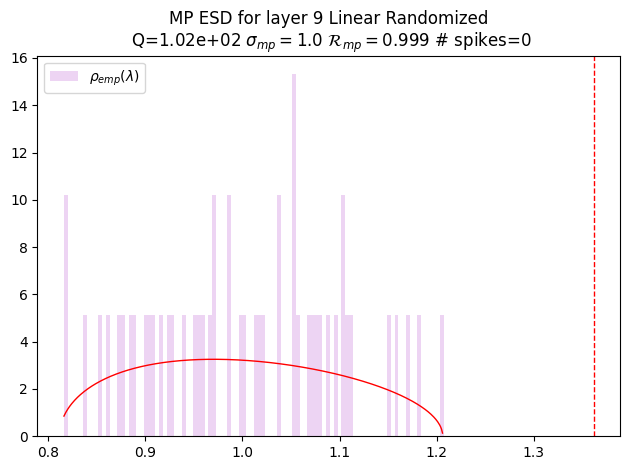

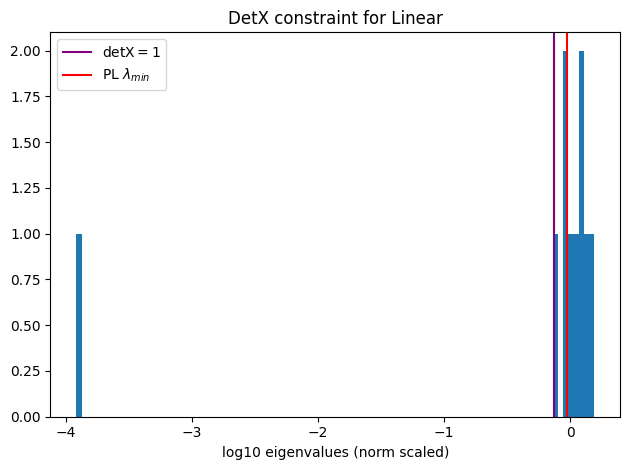

,layer_id,name,D,M,N,Q,alpha,alpha_weighted,detX_num,detX_val,...,stable_rank,status,sv_max,sv_min,warning,weak_rank_loss,ww_maxdist,ww_softrank,xmax,xmin
0,3,Linear,0.028008,2048,3072,1.5,1.409368,1.663024,395,0.020466,...,22.937626,success,3.890354,0.007794,over-trained,0,14.575671,0.036947,15.134855,0.000921
1,6,Linear,0.035350,1024,2048,2.0,1.892128,2.052925,476,0.095100,...,27.400106,success,3.487316,0.078955,over-trained,0,5.774521,0.525175,12.161370,0.158807
2,9,Linear,0.140890,10,1024,102.4,5.497270,5.673068,10,5.219912,...,6.445583,success,3.280874,0.028977,,0,2.808688,0.739070,10.764137,6.506653


<Figure size 640x480 with 0 Axes>

In [18]:
import weightwatcher as ww
watcher = ww.WeightWatcher(model=model)
watcher.analyze(plot=True, randomize=True, detX=True)